In [ ]:
! pip3 install optax

     |████████████████████████████████| 140 kB 12.3 MB/s 
     |████████████████████████████████| 72 kB 632 kB/s 


In [ ]:
import jax.numpy as jnp
from jax import random
import optax
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [ ]:
! git init .
! git remote add origin https://github.com/VLSF/SNO
! git pull origin main

In [ ]:
from architectures import SNOx_1D as vanilla
from datasets import Indefinite_Integrals

from functions import Chebyshev, utils

# 1D

# Write, load and count

In [ ]:
params_encoder = vanilla.init_c_network_params([1, 20, 20, 20], random.PRNGKey(11))
params_i = vanilla.init_i_network_params([100, 100, 100, 100], [20, 20, 20, 20], random.PRNGKey(11))
params_decoder = vanilla.init_c_network_params([20, 20, 20, 1], random.PRNGKey(11))
params = [params_encoder, params_i, params_decoder]

In [ ]:
vanilla.count_params(params)

39345

In [ ]:
vanilla.save_params(params, "chebyshev_33", "vanilla_run_134")
params_ = vanilla.load_params("chebyshev_33", "vanilla_run_134")

In [ ]:
print("Same number of layers --", [len(p) == len(p_) for p, p_ in zip(params, params_)])
print("====")

for p, p_ in zip(params, params_):
  for i in range(len(p)):
    print("Layer " + str(i))
    for j in range(len(p[i])):
      print(jnp.all(p[i][j] == p_[i][j]))
    print("====")

# Training I

Initialize network with three layers

In [ ]:
params_encoder = vanilla.init_c_network_params([1, 10, 10, 10], random.PRNGKey(11))
params_i = vanilla.init_i_network_params([20, 20, 20, 20], [10, 10, 10, 10], random.PRNGKey(11))
params_decoder = vanilla.init_c_network_params([10, 10, 10, 1], random.PRNGKey(11))
params = [params_encoder, params_i, params_decoder]

vanilla.count_params(params)

2775

Initialize optimizer

In [ ]:
sc = optax.exponential_decay(0.001, 5000, 0.5)
optimizer = optax.adam(sc)
opt_state = optimizer.init(params)

Create dataset

In [ ]:
N_samples = 500
Data = Indefinite_Integrals.Fourier_series(10, 50, 2*N_samples, key=random.PRNGKey(1729), sigma=2, return_coefficients=False, periodic=False)

train = (jnp.expand_dims(Data[0][:250], axis=-1), jnp.expand_dims(Data[1][:250], axis=-1))
test = (jnp.expand_dims(Data[0][250:], axis=-1), jnp.expand_dims(Data[1][250:], axis=-1))

In [ ]:
%timeit -o utils.update_params(params, train[0], train[1], optimizer, opt_state, vanilla.loss);

The slowest run took 5987.81 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 1.05 ms per loop


<TimeitResult : 1 loop, best of 5: 1.05 ms per loop>

In [ ]:
res = _
mean_t = sum(r/res.loops for r in res.all_runs) / len(res.all_runs)
N_epochs = 10000

minutes = N_epochs*mean_t/60

print("Optimization will take ", round(minutes, ndigits=2), " minutes")

Optimization will take  0.21  minutes


In [ ]:
train_loss = []
test_loss = []

test_loss.append(vanilla.loss(params, test[0], test[1]))
train_loss.append(vanilla.loss(params, train[0], train[1]))

print(train_loss[-1])
print(test_loss[-1])

0.8075053017038627
0.8205732833980828


In [ ]:
for i in range(N_epochs):
  # run in a single batch
  params, opt_state = utils.update_params(params, train[0], train[1], optimizer, opt_state, vanilla.loss)
  if (i+1)%100 == 0:
    test_loss.append(vanilla.loss(params, test[0], test[1]))
    train_loss.append(vanilla.loss(params, train[0], train[1]))

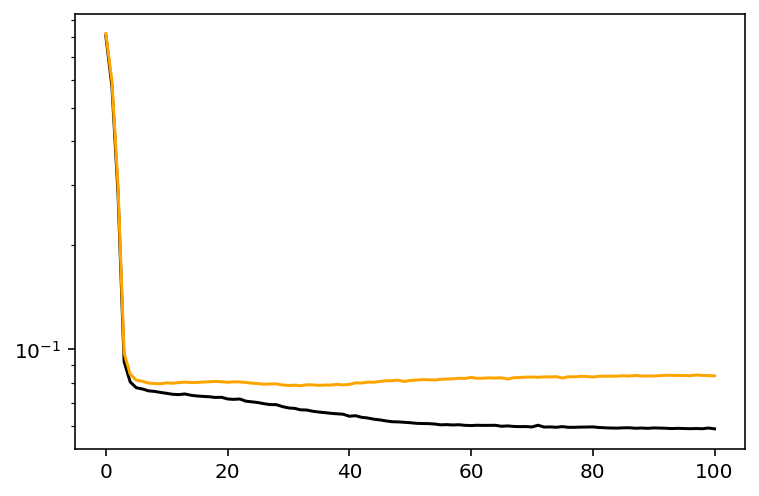

In [ ]:
plt.yscale("log")
plt.plot(train_loss, color="black")
plt.plot(test_loss, color="orange");

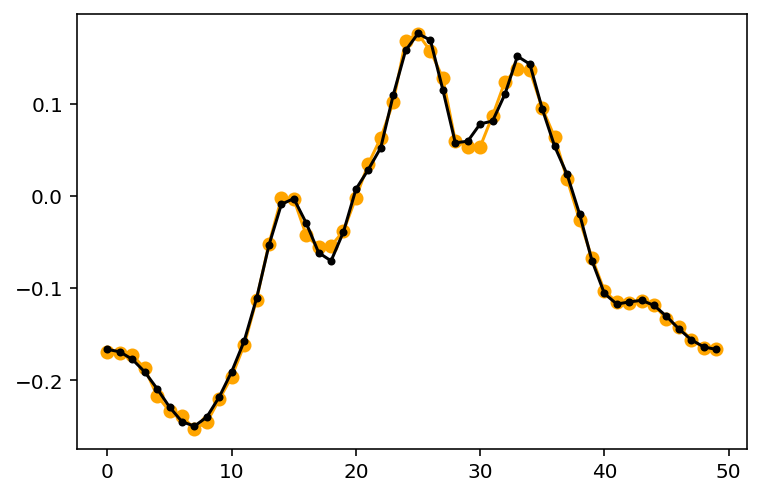

In [ ]:
N = 0
plt.plot(vanilla.NN(params, train[0][N]), "o-", color="orange")
plt.plot(train[1][N], ".-", color="black");

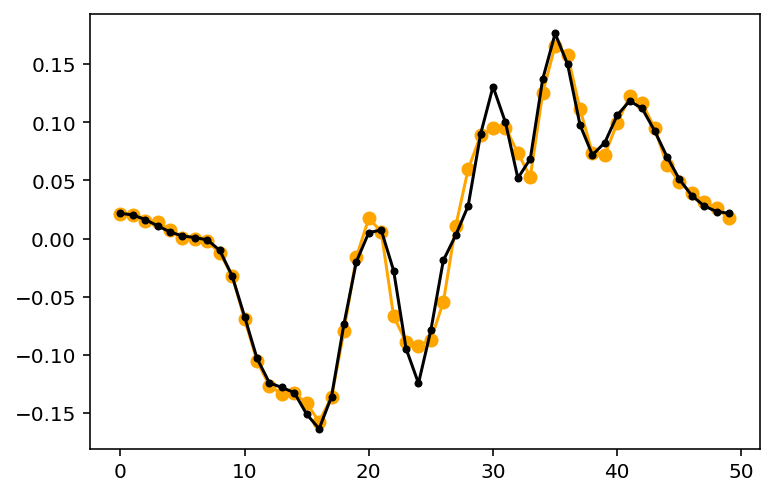

In [ ]:
N = 27
plt.plot(vanilla.NN(params, test[0][N]), "o-", color="orange")
plt.plot(test[1][N], ".-", color="black");

Mean relative test error 0.15528617340268214


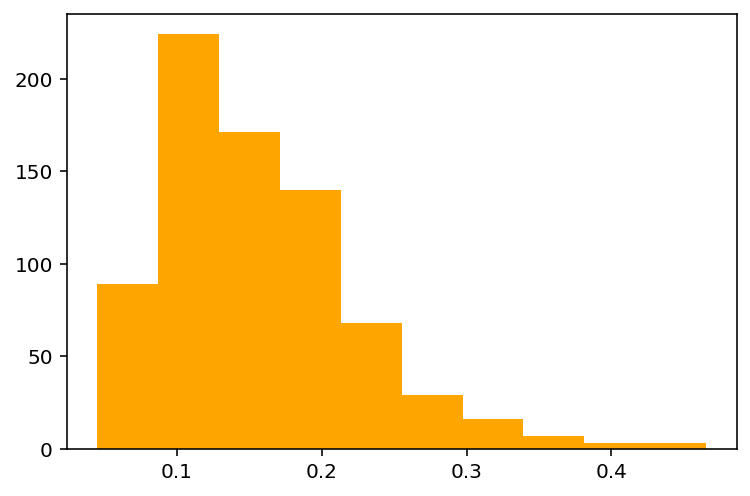

In [ ]:
predictions = vanilla.batched_NN(params, test[0]).reshape(750, 50)
targets = test[1].reshape(750, 50)
relative_errors = jnp.linalg.norm(predictions - targets, axis=1) / jnp.linalg.norm(targets, axis=1)
plt.hist(relative_errors, color="orange")
mean_relative_test_error = jnp.mean(relative_errors)
print("Mean relative test error", mean_relative_test_error);